# Task 1: Bulk RNA-seq data analysis
## Notebook 2: DESeq Analysis


Comparative & Regulatory Genomics - [I0U29a] | Task 1 - Bulk RNA-seq data analysis | Antoine Ruzette <b> r0829308 </b> | 19.12.2021

Based on the DESeq jupyter notebook from Prof. Stein Aerts. 


In [101]:
#NOTE THAT WE ARE ON R NOW!!
library("DESeq2")
library(scales)
options(repr.plot.width=4, repr.plot.height=3)
#load the DESeq library

### Exploration and data pre-processing

In [102]:
matrixFile = path.expand("all.gene.counts")

In [159]:
countData <- as.matrix(read.csv(matrixFile, sep="\t", row.names="Geneid"))
head(countData)
nrow(countData)

,SRR13516818_1.fastq.bam,SRR13516819_1.fastq.bam,SRR13516821_1.fastq.bam,SRR13516823_1.fastq.bam
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,0
RP11-34P13.8,0,0,0,0
AL627309.1,0,0,0,0


[1] 41863

Let's check a single gene, i.e MTOR: 

In [105]:
countData['FNIP1',]

SRR13516818_1.fastq.bam SRR13516819_1.fastq.bam SRR13516821_1.fastq.bam 
                   2602                    3425                    1048 
SRR13516823_1.fastq.bam 
                   1064

Rename the column names for a better interpretability (MB1 are library generated from treated cells and CTL are library generated from control, i.e DMSO, cells): 

,CTL_1,CTL_2,MB1_1,MB1_2
MIR1302-11,0,0,0,0
FAM138A,0,0,0,0
OR4F5,0,0,0,0
RP11-34P13.7,0,0,0,0
RP11-34P13.8,0,0,0,0
AL627309.1,0,0,0,0


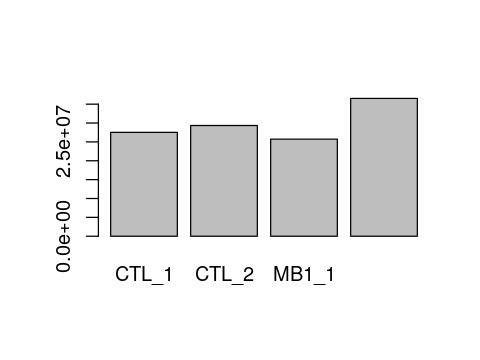

In [106]:
colnames(countData) <- c("MB1_1", "MB1_2", "CTL_1", "CTL_2")
#barplot(colSums(countData))
countData = countData[, c(3, 4, 1, 2)] #change the order of the columns to match the interpretation of the reference notebook
barplot(colSums(countData))#be sure that the two graphs match
head(countData)

Plot of the total amount of (raw) reads per sample: 

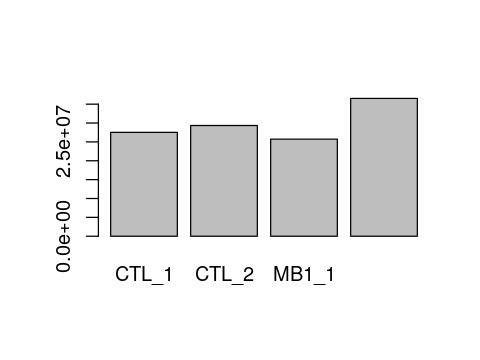

In [107]:
barplot(colSums(countData))

Note that MB1_2 library has more counts than other, so normalization will be needed. 
Another remark is that it is important that the order of the levels is correct. In this case `Control` comes first, which means that we will be comparing $MB1 \over Control$, so positive log fold change values are up in the stiumulated samples.

In [108]:
#formalize our experiment as a condition (two levels as factors)
condition <- factor(c("Control", "Control", "MB1", "MB1"))
print(condition)

[1] Control Control MB1     MB1    
Levels: Control MB1


Prepare a dataframe with the names and conditions. This will be fed to `DESeq2`. Ensure that the order is unchanged!

In [109]:
colData <- data.frame(sampleName = colnames(countData),
                      condition = condition)
colData
#formal structure that is needed for DeSEQ

sampleName,condition
<fct>,<fct>
CTL_1,Control
CTL_2,Control
MB1_1,MB1
MB1_2,MB1


Here we create a DESeq `DESeqDataSet` object for subsequent analysis:

In [110]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = colData,
                              design = ~ condition)
#we need to do this to ensure the column names are correct.
colnames(dds) <- colnames(countData)
dds

class: DESeqDataSet 
dim: 41863 4 
metadata(1): version
assays(1): counts
rownames(41863): MIR1302-11 FAM138A ... AC007965.1 RNU6-1314P
rowData names(0):
colnames(4): CTL_1 CTL_2 MB1_1 MB1_2
colData names(2): sampleName condition

By comparing the condition factor in the dds object to the column names, you can confirm that the order is still correct: 

In [111]:
dds$condition

[1] Control Control MB1     MB1    
Levels: Control MB1

### Run the differential expression 
One function within `DESeq2` runs all steps required and that is:

In [112]:
dds <- DESeq(dds)
#will estimate many things explained in the following red box

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



### Quality Control 

DESeq2 estimates a factor to correct for the library size:

This is very comparable to the sum of all reads per sample of the raw data, however, `DESeq2` is less sensitive to outliers:

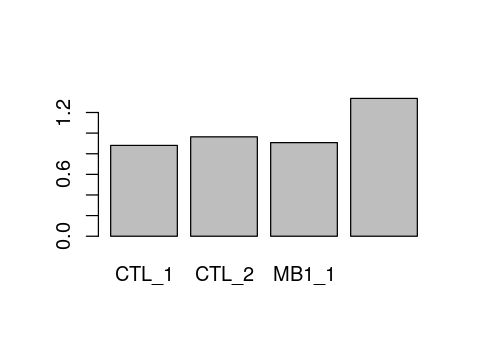

In [113]:
options(repr.plot.width=4, repr.plot.height=3)
barplot(sizeFactors(dds))
#the size factor is logically higher for MB1_2 as there are more reads in MB1_2 than in the other conditions

A scatter plot of sample vs sample will show us how the samples compare; are the replicates more similar than beween stimulated and non-stimulated?

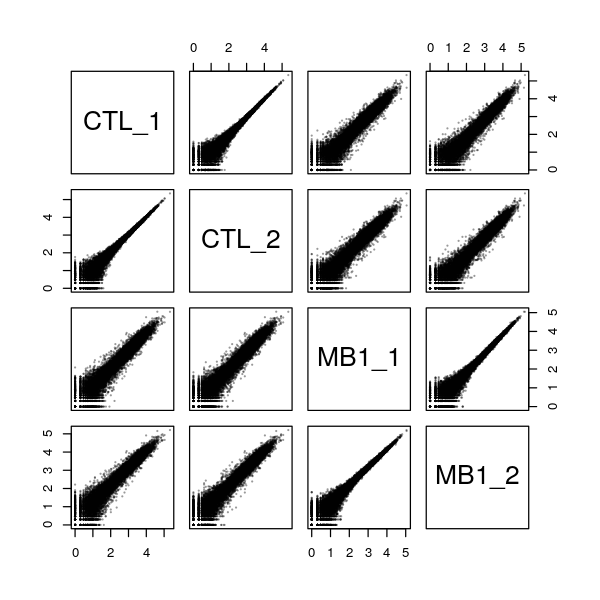

In [152]:
#comparing the different sample to each other
options(repr.plot.width=5, repr.plot.height=5)
plot(data.frame(log10(counts(dds))), cex=0.1, col=alpha("black", 0.4))

There exists a larger spread of the data between CTL_1 and MB1_1 than between CTL_1 and CTL_2, which is a good news since it indicated that something happened during the experiment. 
Indeed, the experiment probably worked as the two conditions do not nicely correlate while it does between similar condition. 

### MA plot

An MA plot show the mean expression vs the log fold change and is a very common method to visualize the results of a differential expression plot. Significantly differentially expressed genes are colored red:

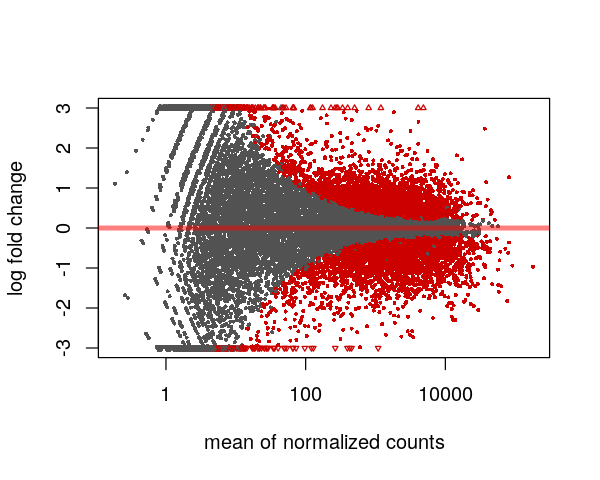

In [116]:
options(repr.plot.width=5, repr.plot.height=4)
plotMA(dds,ylim=c(-3,3))
#red dots = significantly differentially expressed gene

#as you only have two replicates, you cannot calculate variance, etc (then use of Bayesian inference)

### Export the results

In [142]:
res <- results(dds)
res <- res[order(res$padj), ] #ordered by adj p value
head(res)
#one of these top 5 genes we were used as a reference/positive control gene is comprised in the list! Good news! 

#p value needs to be adjusted for multiple testing (10e-250 = so low, really significant, it seems to have worked)

log2 fold change (MLE): condition MB1 vs Control 
Wald test p-value: condition MB1 vs Control 
DataFrame with 6 rows and 6 columns
                 baseMean    log2FoldChange              lfcSE
                <numeric>         <numeric>          <numeric>
TRIB3    36600.4315336803  2.48543044630668 0.0779717448011289
KLHL24   4847.29869700644  3.36267305287895  0.108147118045263
ERN1     4078.53023433434  3.19018707375091  0.111268272060618
PRDX1    12871.2138298292 -2.29527402989532 0.0873532569253344
LDHA     29688.6605252198 -2.04844635849026 0.0803278966631278
HSP90AA1 77235.8493647543 -1.82642127714815 0.0769458400434572
                      stat                pvalue                  padj
                 <numeric>             <numeric>             <numeric>
TRIB3     31.8760398737505 5.73672780705973e-223 8.85291835185458e-219
KLHL24    31.0935058988031 2.94810669591521e-212 2.27475912656818e-208
ERN1      28.6711298258763 8.74222058199542e-181 4.49699826737844e-177
PRDX1     

How many genes are differentially expressed?

In [158]:
res.sign <- res[(!is.na(res$padj)) & (res$padj < 0.05),]
nrow(res.sign)

[1] 5415

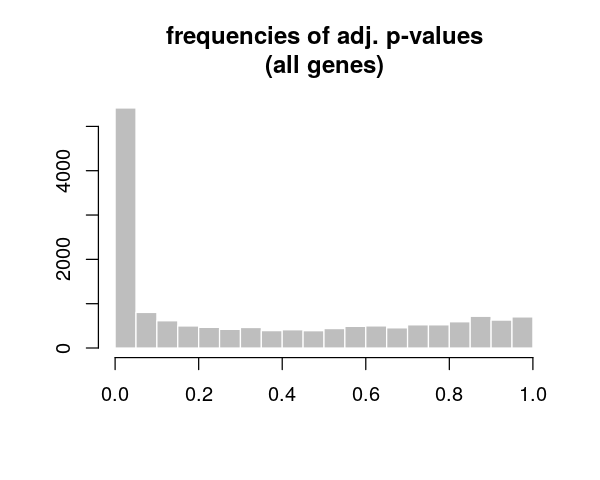

In [119]:
hist(res$padj, 
     col="grey", border="white", xlab="", ylab="", main="frequencies of adj. p-values\n(all genes)")
#plot of p values = we see an enrichment around low p values (normally you would see uniform distribution)

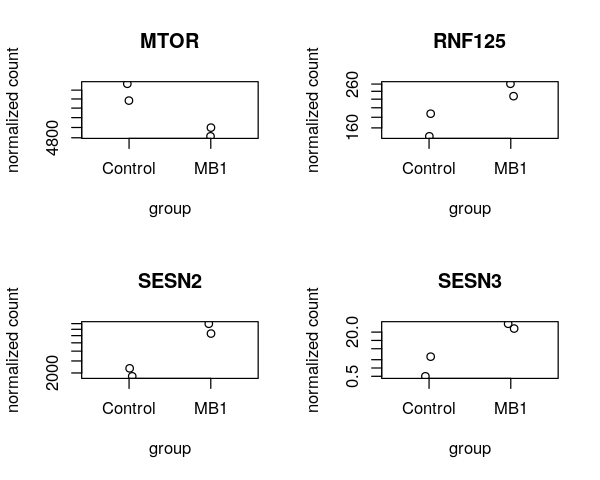

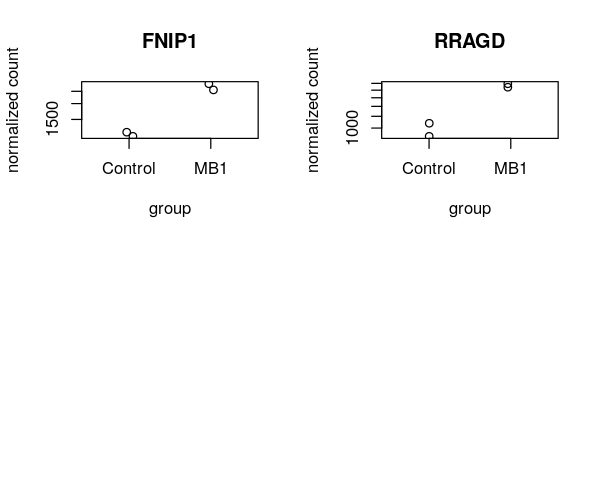

In [121]:
par(mfrow=c(2,2))
for (genes in c("MTOR", "RNF125", "SESN2", "SESN3", "FNIP1", "RRAGD"))
    {
    plotCounts(dds, gene= genes, normalized = TRUE)  
    }

Save to disk:

In [122]:
write.table(res, "deseq.results.tsv", sep="\t", col.names=NA, quote=FALSE)

It is alwasy important to manually check a number of diff. expressing genes. As expected, all the expression levels of the negative regulators of mTORc1 goes up in the MB1-treated cells: 

log2 fold change (MLE): condition MB1 vs Control 
Wald test p-value: condition MB1 vs Control 
DataFrame with 1 row and 6 columns
               baseMean   log2FoldChange             lfcSE             stat
              <numeric>        <numeric>         <numeric>        <numeric>
RNF125 204.812488326132 0.55358308511699 0.322700409095979 1.71547066416126
                   pvalue              padj
                <numeric>         <numeric>
RNF125 0.0862589693995417 0.185548625806656

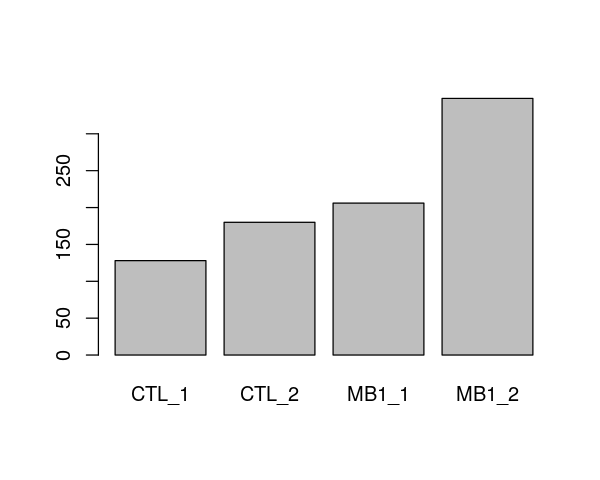

In [130]:
res['RNF125', ]
barplot(counts(dds)["RNF125",]) 

log2 fold change (MLE): condition MB1 vs Control 
Wald test p-value: condition MB1 vs Control 
DataFrame with 1 row and 6 columns
              baseMean   log2FoldChange            lfcSE             stat
             <numeric>        <numeric>        <numeric>        <numeric>
SESN2 3300.76375790605 1.17287236809096 0.12848621513228 9.12839067508883
                    pvalue                 padj
                 <numeric>            <numeric>
SESN2 6.95250818634885e-20 1.88892792837562e-18

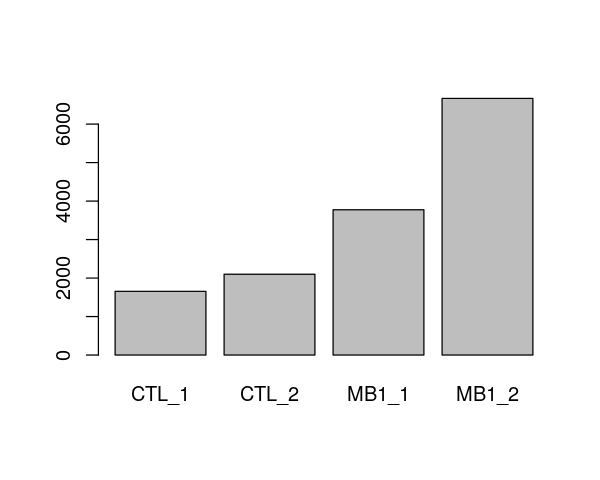

In [131]:
res['SESN2', ]
barplot(counts(dds)["SESN2",]) 

log2 fold change (MLE): condition MB1 vs Control 
Wald test p-value: condition MB1 vs Control 
DataFrame with 1 row and 6 columns
              baseMean   log2FoldChange            lfcSE             stat
             <numeric>        <numeric>        <numeric>        <numeric>
SESN3 17.0386956857199 4.95373737025232 1.47874658384575 3.34995693269446
                    pvalue                padj
                 <numeric>           <numeric>
SESN3 0.000808241260002863 0.00335741026227838

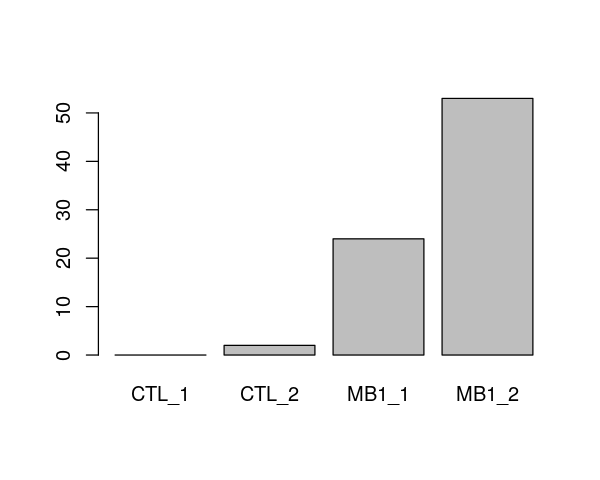

In [132]:
res['SESN3', ]
barplot(counts(dds)["SESN3",]) 

log2 fold change (MLE): condition MB1 vs Control 
Wald test p-value: condition MB1 vs Control 
DataFrame with 1 row and 6 columns
              baseMean   log2FoldChange            lfcSE             stat
             <numeric>        <numeric>        <numeric>        <numeric>
FNIP1 1930.33007204913 1.24242266804123 0.13127196415632 9.46449362608557
                    pvalue                 padj
                 <numeric>            <numeric>
FNIP1 2.94986835668341e-21 8.83929485055113e-20

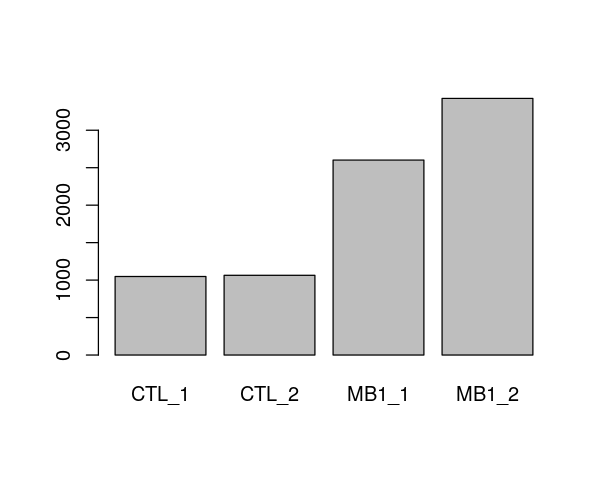

In [127]:
res['FNIP1', ]
barplot(counts(dds)["FNIP1",]) 

log2 fold change (MLE): condition MB1 vs Control 
Wald test p-value: condition MB1 vs Control 
DataFrame with 1 row and 6 columns
             baseMean    log2FoldChange             lfcSE             stat
            <numeric>         <numeric>         <numeric>        <numeric>
RRAGD 1456.7014491063 0.983690212197364 0.149981743183038 6.55873302523804
                    pvalue                 padj
                 <numeric>            <numeric>
RRAGD 5.42668562486674e-11 6.53234107355254e-10

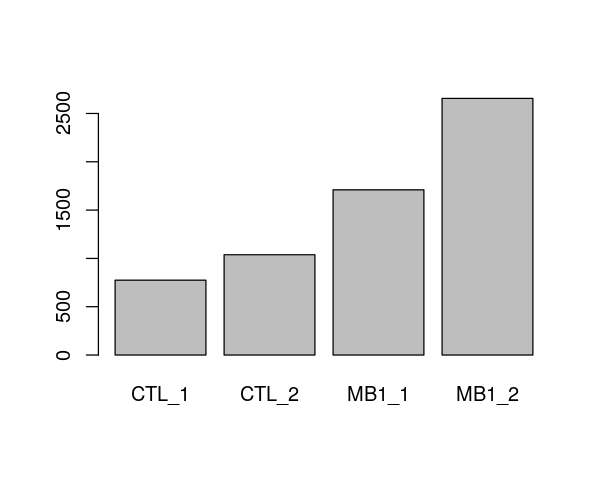

In [128]:
res['RRAGD', ]
barplot(counts(dds)["RRAGD",]) 

log2 fold change (MLE): condition MB1 vs Control 
Wald test p-value: condition MB1 vs Control 
DataFrame with 1 row and 6 columns
             baseMean     log2FoldChange              lfcSE              stat
            <numeric>          <numeric>          <numeric>         <numeric>
MTOR 5333.65702836345 -0.228433677139819 0.0976506097150718 -2.33929596350039
                 pvalue              padj
              <numeric>         <numeric>
MTOR 0.0193201214706711 0.054267949496796

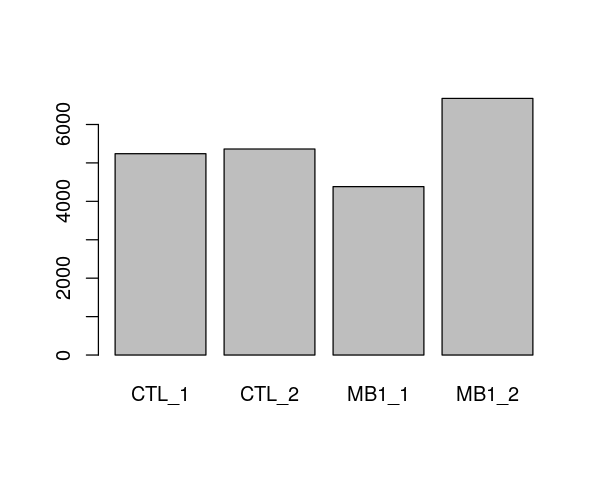

In [123]:
res['MTOR', ]
barplot(counts(dds)["MTOR",]) 